This notebook implements HDB resale price prediction prediction. It covers EDA, Feature engineering - transformation, reduction, outlier removal, scaling, preprocessing. At last we use refined dataset to make predictions

**Please note that** we have extracted the information out of all 7 auxiliary data csv files and made a new train csv file by adding these columns to existing columns. New columns are : mrt (for MRTs), hawker (for hawker market and centers), cc (for commercial centers), sm (for shopping malls), ps (for primary school) and ss (for secondary school) and pop_avg_age which contains average age of the population corresponding to subzone and planning area of each house. Nearest distance is in meters



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler , MinMaxScaler, MaxAbsScaler 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../input/new-dataset/train_final.csv')
train_df.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,planning_area,region,resale_price,mrt,hawker,ps,ss,sm,cc,pop_avg_age
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,pasir ris,east region,209700.0,1137.16,945.56,344.09,428.30,1033.22,2313.57,37.171904
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,punggol,north-east region,402300.0,824.05,3782.39,160.85,312.38,806.04,1462.43,34.546316
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,sengkang,north-east region,351000.0,2230.48,1803.94,184.91,558.38,452.56,1444.92,32.509407


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                431732 non-null  object 
 1   town                 431732 non-null  object 
 2   flat_type            431732 non-null  object 
 3   block                431732 non-null  object 
 4   street_name          431732 non-null  object 
 5   storey_range         431732 non-null  object 
 6   floor_area_sqm       431732 non-null  float64
 7   flat_model           431732 non-null  object 
 8   eco_category         431732 non-null  object 
 9   lease_commence_date  431732 non-null  int64  
 10  latitude             431732 non-null  float64
 11  longitude            431732 non-null  float64
 12  elevation            431732 non-null  float64
 13  subzone              431732 non-null  object 
 14  planning_area        431732 non-null  object 
 15  region           

In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,431732.0,96.970064,25.190664,31.000000,74.000000,99.000000,114.000000,2.800000e+02
lease_commence_date,431732.0,1989.421004,10.254055,1966.000000,1983.000000,1988.000000,1997.000000,2.019000e+03
latitude,431732.0,1.364939,0.042829,1.270380,1.336154,1.358958,1.389004,1.457071e+00
longitude,431732.0,103.836492,0.073527,103.685228,103.772439,103.840160,103.895779,1.039878e+02
elevation,431732.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
resale_price,431732.0,301819.588443,129862.345928,29700.000000,205200.000000,283950.000000,373500.000000,1.123200e+06
mrt,431732.0,921.159841,663.204036,36.270000,502.810000,768.490000,1125.230000,5.876640e+03
hawker,431732.0,1006.008119,942.407958,1.880000,350.770000,677.760000,1276.270000,4.826480e+03
ps,431732.0,394.019117,230.756157,33.370000,230.170000,350.350000,505.580000,3.305840e+03
ss,431732.0,503.855123,320.730715,15.850000,284.960000,444.220000,628.460000,3.580370e+03


# **elevation, eco_category**

We observe that, for columns **elevation** and **eco_category** all rows have same value. Therefore, these features will not add any value to our resale price prediction. We can safely drop them.

In [5]:
train_df['elevation'].value_counts()

0.0    431732
Name: elevation, dtype: int64

In [6]:
train_df['eco_category'].value_counts()

uncategorized    431732
Name: eco_category, dtype: int64

In [7]:
train_df.drop(['elevation','eco_category'], axis=1, inplace=True)

# **month**

In [8]:
train_df['month'].head(3)

0    2001-08
1    2014-10
2    2020-09
Name: month, dtype: object

From a general view point, resale prices will vary over the years but month of the year specifically will not matter that much. Therefore, we keep only years

In [9]:
train_df['month'] = pd.to_datetime(train_df['month'])
train_df['resale_year'] = pd.DatetimeIndex(train_df['month']).year
train_df['resale_month'] = pd.DatetimeIndex(train_df['month']).month
train_df.drop(['month'], axis=1, inplace=True)

Corelation of resale year with resale price is very high so can keep this column

In [10]:
train_df.corr()['resale_price']['resale_year']

0.5787168351130808

Corelation of resale month with resale price is very low so can drop this column

In [11]:
train_df.corr()['resale_price']['resale_month']

0.025447506087335394

In [12]:
train_df.drop(['resale_month'], axis=1, inplace=True)

Correlation to target variable

In [13]:
train_df.corr()['resale_price']

floor_area_sqm         0.570385
lease_commence_date    0.423578
latitude              -0.065915
longitude              0.099786
resale_price           1.000000
mrt                   -0.117223
hawker                 0.121804
ps                    -0.045557
ss                     0.056814
sm                    -0.074985
cc                    -0.128548
pop_avg_age           -0.133386
resale_year            0.578717
Name: resale_price, dtype: float64

# Heatmap of correlation among all columns

We observe that floor area, lease commencement date and resale year has a high corelation to target variable resale price

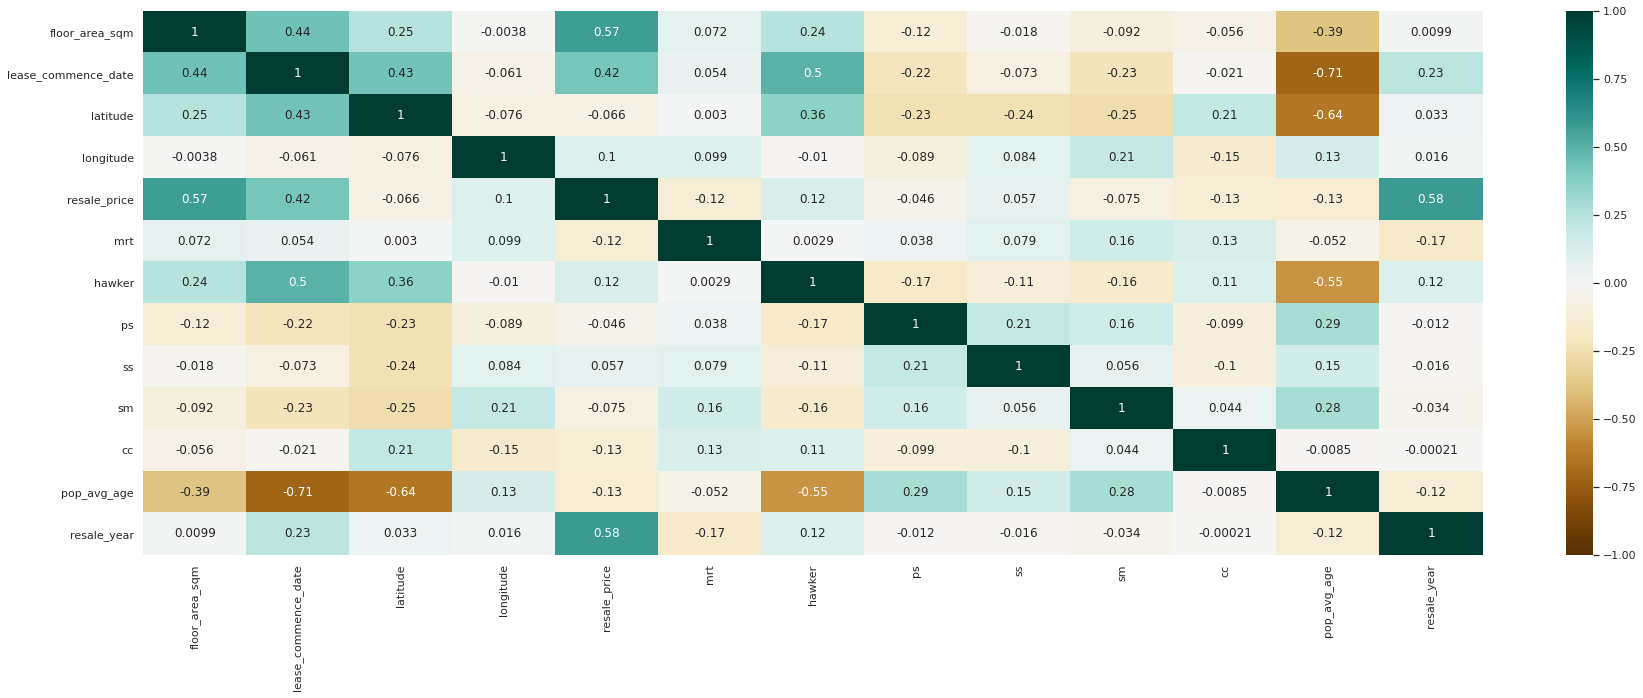

In [14]:
sns.set(rc={'figure.figsize':(30,10)})
heatmap = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Check if any missing values

we notice that population average age has few mising values. We will look into it later when we analyze auxilary data columns

<AxesSubplot:>

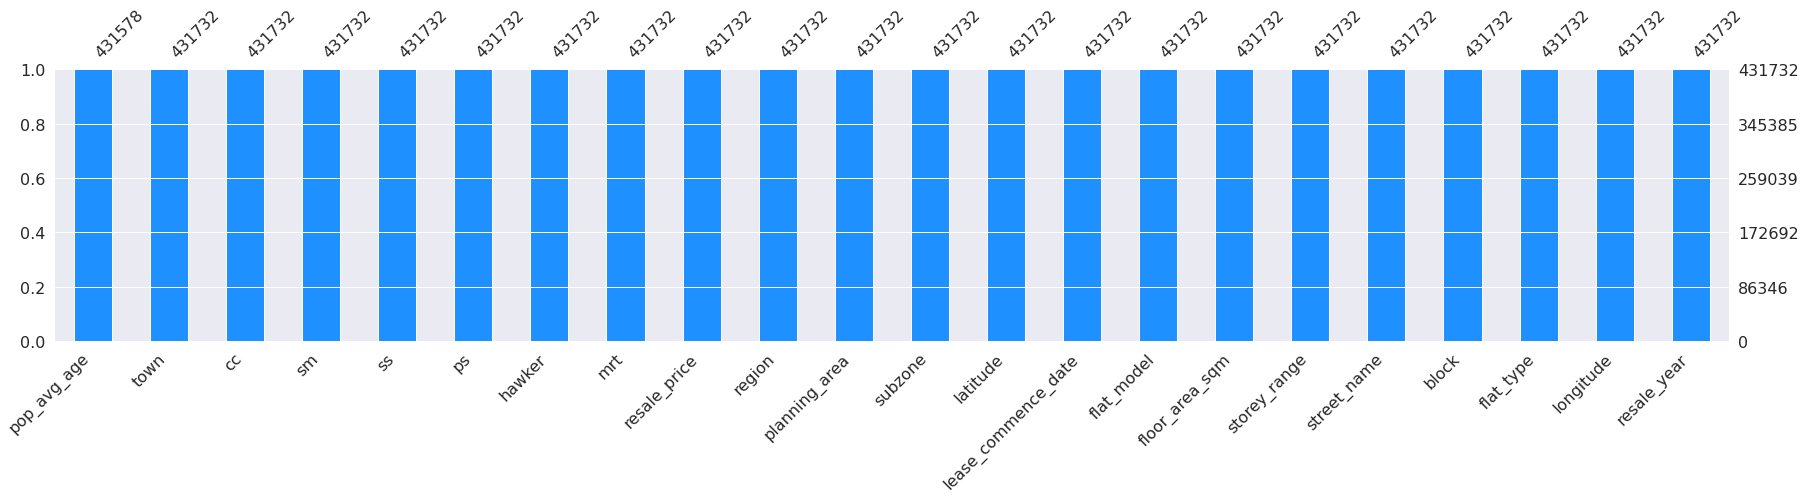

In [15]:
msno.bar(train_df, color="dodgerblue", sort="ascending", figsize=(30,5))

# **flat_type**

In [16]:
train_df['flat_type'].value_counts()

4 room              135679
3 room               99886
5 room               77133
4-room               33918
executive            32724
3-room               25835
5-room               21564
2 room                3580
2-room                 942
1 room                 222
multi generation       185
1-room                  64
Name: flat_type, dtype: int64

The flat type column has inconsistent values(eg. 1-room and 1 room). As both are essentially the same, they are merged together and denoted using a common value(1 room).

In [17]:
d = {
    '1-room' : '1 room',
    '2-room' : '2 room',
    '3-room' : '3 room',
    '4-room' : '4 room',
    '5-room' : '5 room'
}
def changeFlatType(ft):
    if ft in d.keys():
        return d[ft]
    else:
        return ft

In [18]:
train_df['flat_type'] = train_df['flat_type'].apply(changeFlatType)

we can observe that as number of roooms increases the resale price also increases

<AxesSubplot:xlabel='flat_type', ylabel='resale_price'>

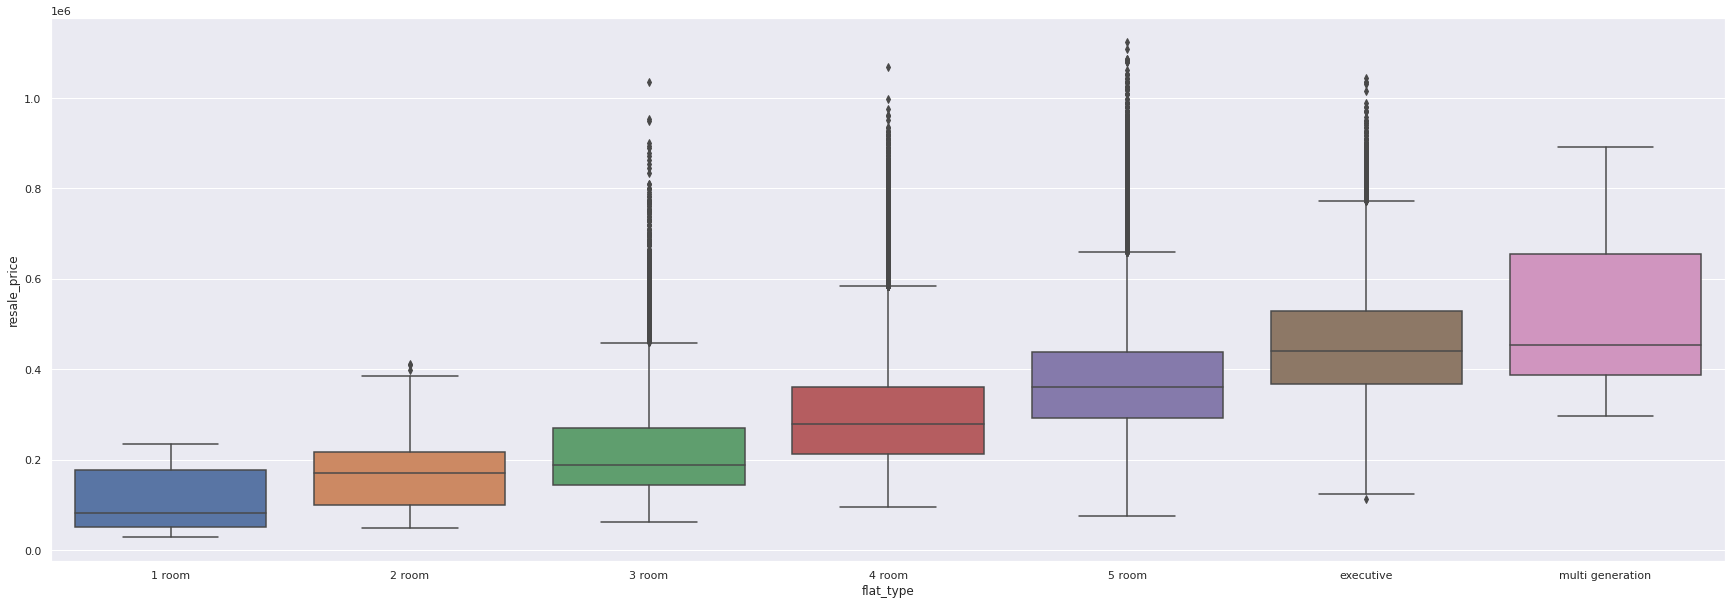

In [19]:
sns.boxplot(x='flat_type', y='resale_price', data=train_df.sort_values(by='flat_type'))

In [20]:
train_df['flat_type'].value_counts()

4 room              169597
3 room              125721
5 room               98697
executive            32724
2 room                4522
1 room                 286
multi generation       185
Name: flat_type, dtype: int64

# **storey_range**

In [21]:
train_df['storey_range'].value_counts()

04 to 06    107275
07 to 09     95732
01 to 03     86231
10 to 12     81616
13 to 15     30857
16 to 18     12140
19 to 21      5541
22 to 24      3555
01 to 05      2178
06 to 10      1985
25 to 27      1643
11 to 15       993
28 to 30       866
34 to 36       221
31 to 33       220
37 to 39       215
16 to 20       209
40 to 42       109
21 to 25        69
26 to 30        29
46 to 48        19
43 to 45        14
49 to 51         7
36 to 40         6
31 to 35         2
Name: storey_range, dtype: int64

The mean of the storey range values is calculated for generalisation to prevent overlapping of two range values (eg.01-03 and 01-05 result in overlap)


In [22]:
def get_mean_floor(x):
    return int( ( int(x[:2]) + int(x[-2:])  ) * 0.5)

In [23]:
train_df['storey_range'] = train_df['storey_range'].map(lambda x: get_mean_floor(x))

In [24]:
train_df['storey_range'].value_counts()

5     107275
8      97717
2      86231
11     81616
14     30857
17     12140
20      5541
23      3624
3       2178
26      1643
13       993
29       866
35       221
38       221
32       220
18       209
41       109
28        29
47        19
44        14
50         7
33         2
Name: storey_range, dtype: int64

<AxesSubplot:xlabel='storey_range', ylabel='resale_price'>

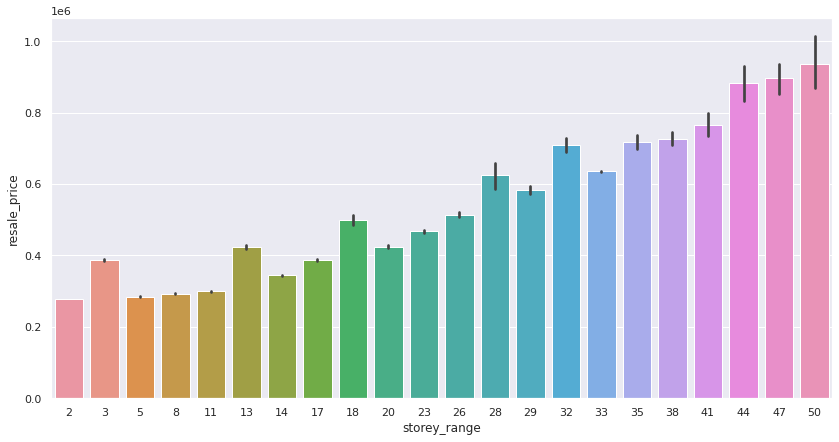

In [25]:
sns.set(rc={'figure.figsize':(14,7)})
sns.barplot(x='storey_range', y='resale_price', data=train_df.sort_values(by='resale_price'))

# **floor_area_sqm**

<AxesSubplot:xlabel='floor_area_sqm', ylabel='resale_price'>

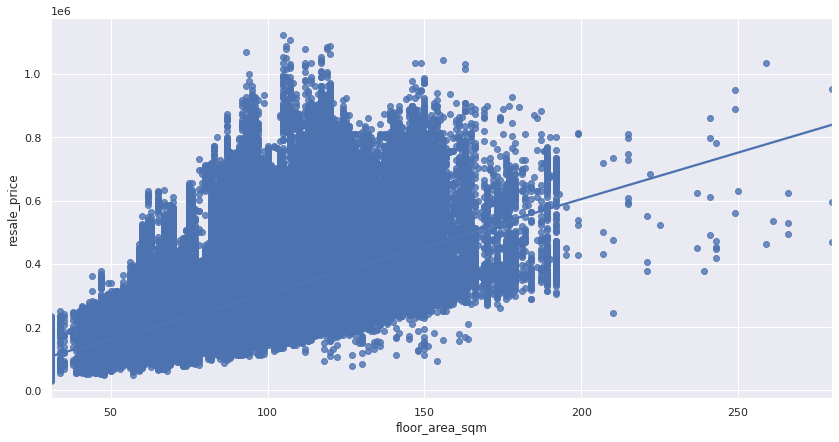

In [26]:
sns.regplot(x="floor_area_sqm",y="resale_price",data=train_df)

We observe that floor area has high positive corelation to resale price. We can also conclude from the plot above that there exists potential outliers. 
Removing such outlier directly based on resale price may not be best way forward as price varies based on size of the house. Therefore we create a new feature, resale_price_per_floor_area_sqm to spot and remove potential outliers

In [27]:
resale_price_per_floor_area_sqm = train_df['resale_price'] / train_df['floor_area_sqm']

In [28]:
mean = resale_price_per_floor_area_sqm.mean()
std = resale_price_per_floor_area_sqm.std()
mean,std

(3123.8458721744337, 1128.1311718567506)

In [29]:
#values less than 2 std. deviation of mean
train_df[resale_price_per_floor_area_sqm < (mean - 2*std)]['region'].value_counts()

west region       5
central region    2
Name: region, dtype: int64

In [30]:
lt_index = train_df[resale_price_per_floor_area_sqm < (mean - 2*std)].index
len(lt_index)

7

In [31]:
#values greater than 3.5 std. deviation of mean
train_df[resale_price_per_floor_area_sqm > (mean + 3.5*std)]['region'].value_counts()

central region       3089
west region           151
north-east region      49
east region            39
Name: region, dtype: int64

we observe that there are significant number of houses which belong to central region. This matches with our prior knowledge that resale prices are higher in central region. Therefore we can ignore central region houses as outliers here and remove houses from remaining area

In [32]:
reg_gt_3_std = train_df[resale_price_per_floor_area_sqm > (mean + 3.5*std)]['region']
gt_index = reg_gt_3_std[reg_gt_3_std !='central region'].index
len(gt_index)

239

In [33]:
outlier_index = lt_index.append(gt_index)
len(outlier_index)

246

In [34]:
train_df = train_df.drop(outlier_index)

# **lease commencement data**

Lease commencement data is also strongly related to resale_price same can be inferred from the plot below

<AxesSubplot:xlabel='lease_commence_date', ylabel='resale_price'>

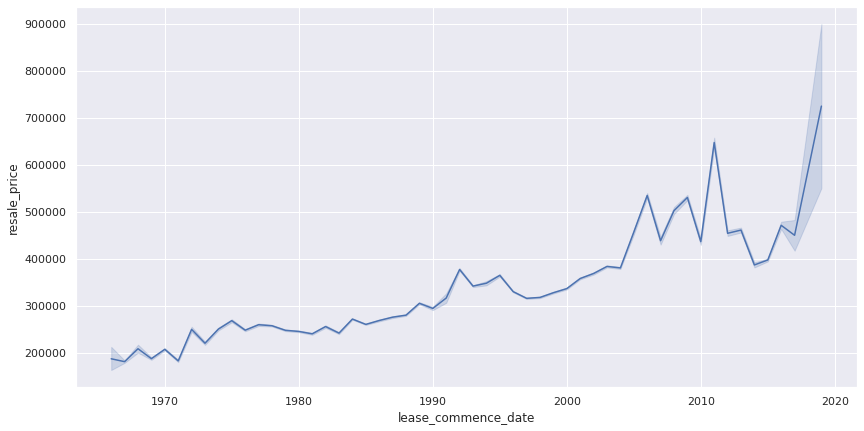

In [35]:
sns.lineplot(x='lease_commence_date', y='resale_price', data=train_df)

# **flat_model**

In [36]:
train_df['flat_model'].value_counts()

model a                   127463
improved                  113879
new generation             78355
premium apartment          28393
simplified                 24752
apartment                  17794
standard                   17791
maisonette                 11911
model a2                    7380
dbss                        1240
adjoined flat                817
model a maisonette           725
terrace                      312
type s1                      220
multi generation             185
type s2                      106
premium maisonette            67
improved maisonette           51
premium apartment loft        26
2 room                        19
Name: flat_model, dtype: int64

In [37]:
train_df[train_df['flat_model'] == '2 room']

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,...,region,resale_price,mrt,hawker,ps,ss,sm,cc,pop_avg_age,resale_year
9287,pasir ris,2 room,142,pasir ris street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,136800.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2003
28046,pasir ris,2 room,142,pasir ris street 11,2,58.0,2 room,1994,1.363453,103.958902,...,east region,121500.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2003
40688,sengkang,2 room,448B,Sengkang West Way,23,46.0,2 room,2014,1.393420,103.873320,...,north-east region,204300.0,2470.86,2317.07,175.42,606.80,351.12,1270.24,32.509407,2020
103130,pasir ris,2 room,142,Pasir Ris Street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,229500.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2010
167957,pasir ris,2 room,142,Pasir Ris Street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,169200.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2007
172279,pasir ris,2 room,142,pasir ris street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,122400.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2002
177411,pasir ris,2 room,142,pasir ris street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,133200.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2004
207255,pasir ris,2 room,142,Pasir Ris Street 11,2,58.0,2 room,1994,1.363453,103.958902,...,east region,171000.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2009
213572,pasir ris,2 room,142,pasir ris street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,135000.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2005
214833,pasir ris,2 room,142,Pasir Ris Street 11,2,55.0,2 room,1994,1.363453,103.958902,...,east region,207000.0,1506.23,1380.39,344.79,409.35,1424.09,1904.94,37.171904,2009


We observe there are 2 corrupt records here corresponding to street - 'Sengkang West Way' and street 'jalan kayu'. We replace their flat model we appropiate flat model below

In [38]:
train_df[(train_df['street_name'] == 'Sengkang West Way') & (train_df['floor_area_sqm'] == 46)]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,...,region,resale_price,mrt,hawker,ps,ss,sm,cc,pop_avg_age,resale_year
35349,sengkang,2 room,450B,Sengkang West Way,14,46.0,model a,2014,1.394048,103.873346,...,north-east region,214200.0,2474.42,2377.93,207.49,639.86,389.90,1274.36,32.509407,2019
40688,sengkang,2 room,448B,Sengkang West Way,23,46.0,2 room,2014,1.393420,103.873320,...,north-east region,204300.0,2470.86,2317.07,175.42,606.80,351.12,1270.24,32.509407,2020
171628,sengkang,2 room,448B,Sengkang West Way,8,46.0,model a,2014,1.393420,103.873320,...,north-east region,211500.0,2470.86,2317.07,175.42,606.80,351.12,1270.24,32.509407,2018
172618,sengkang,2 room,450C,Sengkang West Way,11,46.0,model a,2014,1.393815,103.873364,...,north-east region,208800.0,2469.76,2353.85,190.64,624.21,371.97,1275.51,32.509407,2019


In [39]:
train_df.loc[40688 , 'flat_model'] = 'model a' 

In [40]:
train_df[(train_df['street_name'] == 'jalan kayu') & (train_df['floor_area_sqm'] == 47)]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,...,region,resale_price,mrt,hawker,ps,ss,sm,cc,pop_avg_age,resale_year
25105,sengkang,2 room,447A,jalan kayu,14,47.0,model a,2013,1.392138,103.872491,...,north-east region,234900.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2017
32503,sengkang,2 room,447A,jalan kayu,17,47.0,model a,2013,1.392138,103.872491,...,north-east region,220500.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2020
106802,sengkang,2 room,447A,jalan kayu,20,47.0,model a,2013,1.392138,103.872491,...,north-east region,234000.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2018
127463,sengkang,2 room,447B,jalan kayu,14,47.0,model a,2013,1.392466,103.873208,...,north-east region,224100.0,2456.79,2229.61,183.34,577.19,321.44,1263.23,32.509407,2019
162847,sengkang,2 room,447A,jalan kayu,20,47.0,model a,2013,1.392138,103.872491,...,north-east region,245250.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2017
164839,sengkang,2 room,447A,jalan kayu,5,47.0,model a,2013,1.392138,103.872491,...,north-east region,220500.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2018
192060,sengkang,2 room,447A,jalan kayu,20,47.0,model a,2013,1.392138,103.872491,...,north-east region,252000.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2017
223921,sengkang,2 room,447B,jalan kayu,8,47.0,2 room,2013,1.392466,103.873208,...,north-east region,208800.0,2456.79,2229.61,183.34,577.19,321.44,1263.23,32.509407,2020
251457,sengkang,2 room,447B,jalan kayu,20,47.0,model a,2013,1.392466,103.873208,...,north-east region,238500.0,2456.79,2229.61,183.34,577.19,321.44,1263.23,32.509407,2017
362469,sengkang,2 room,447A,jalan kayu,14,47.0,model a,2013,1.392138,103.872491,...,north-east region,234000.0,2513.69,2238.14,270.11,644.67,393.87,1188.07,32.509407,2017


In [41]:
train_df.loc[223921 , 'flat_model'] = 'model a' 

since there are around 20 types of flat_model, it is not ideal to one hot encode, as there will be many new columns and ultimately poor results. So we convert flat model to numerical feature. We create new numerical column ‘upmarket_model’ which is computed by taking difference of model median price and overall median price. 

Higher positive value of upmarket_model will signify that, that paticular model is more premium than other models, similarily negative values will signify that model is less premium

In [42]:
train_df.groupby(by='flat_model').median()

,storey_range,floor_area_sqm,lease_commence_date,latitude,longitude,resale_price,mrt,hawker,ps,ss,sm,cc,pop_avg_age,resale_year
flat_model,,,,,,,,,,,,,,
2 room,2.0,55.0,1994.0,1.363453,103.958902,171000.0,1506.23,1380.390,344.79,409.35,1424.09,1904.940,37.171904,2008.0
adjoined flat,8.0,136.0,1978.0,1.325737,103.842251,391500.0,681.43,303.140,439.57,507.91,766.13,1924.390,41.842848,2008.0
apartment,8.0,144.0,1995.0,1.375637,103.837437,431496.0,780.20,1050.500,316.80,430.04,520.91,1703.890,36.742657,2008.0
dbss,11.0,108.0,2011.0,1.356073,103.853671,673149.6,525.23,414.680,379.79,642.92,691.58,807.840,38.704239,2018.0
improved,8.0,113.0,1988.0,1.349556,103.845766,302400.0,768.41,585.280,362.19,479.07,610.88,1581.250,38.844120,2008.0
improved maisonette,2.0,137.0,1983.0,1.354986,103.888557,432000.0,696.24,452.260,498.37,495.61,635.50,1009.170,41.552470,2009.0
maisonette,5.0,147.0,1988.0,1.357188,103.848601,450000.0,766.05,811.170,347.76,437.40,624.31,1781.440,38.677135,2009.0
model a,8.0,102.0,1993.0,1.364846,103.833791,278100.0,806.57,836.780,336.72,428.65,583.62,1659.090,38.236602,2008.0
model a maisonette,5.0,140.0,1984.0,1.337552,103.887900,412200.0,890.46,448.390,441.37,317.62,990.32,1833.710,41.552470,2008.0


In [43]:
overall_median_price = train_df['resale_price'].median()
dict_model_to_resale_price = dict(train_df.groupby(by='flat_model')['resale_price'].median())
train_df['upmarket_model'] = train_df['flat_model'].apply(lambda model: dict_model_to_resale_price[model] - overall_median_price)

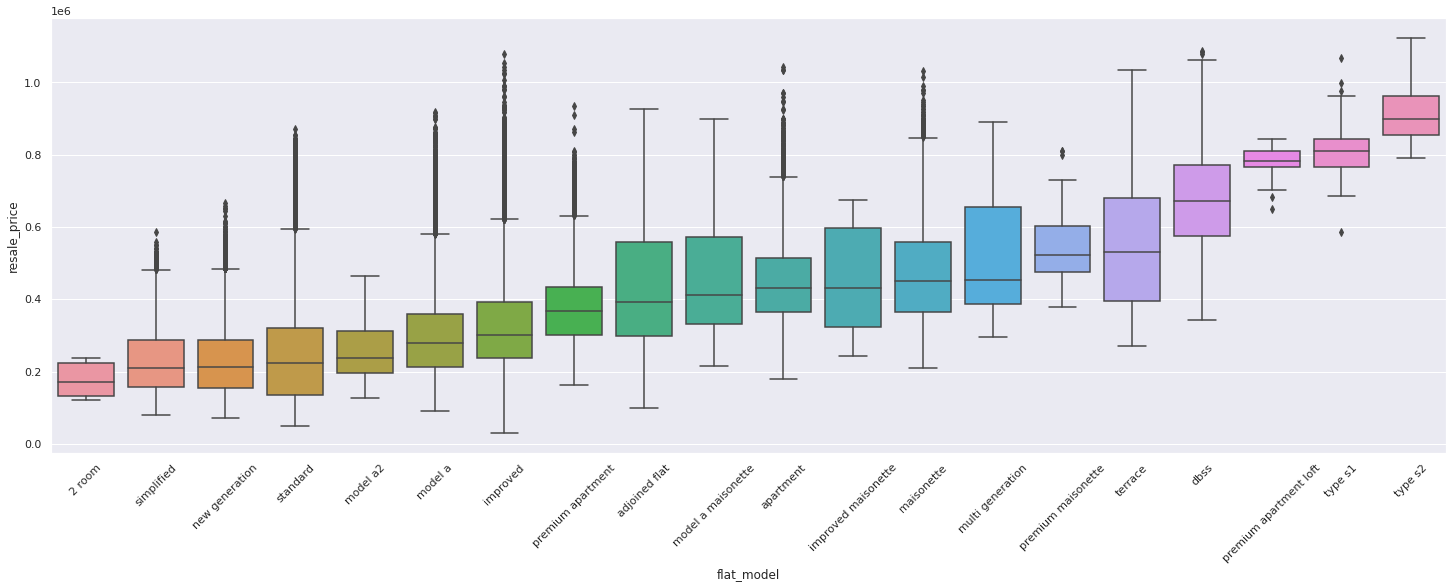

In [44]:
sns.set(rc={'figure.figsize':(25,8)})
sns.boxplot(x ='flat_model', y ='resale_price', data = train_df.sort_values(by="upmarket_model", ascending=True))
plt.xticks(rotation=45);

To conclude above plot, type s2 is most premium model, whereas 2 room is least premium model

# **Town**

In [45]:
train_df['town'].nunique()

26

we notice town do have an effect on resale price as we see that median resale price varies from one town to another

In [46]:
train_df.groupby(by='town').median()['resale_price'].sort_values(ascending=False)

town
bukit timah        394200.0
punggol            394200.0
sengkang           366300.0
bishan             362700.0
pasir ris          346950.0
marine parade      332550.0
bukit merah        321300.0
sembawang          317700.0
central area       308700.0
tampines           301500.0
choa chu kang      292500.0
serangoon          290700.0
bukit panjang      288000.0
kallang/whampoa    287100.0
hougang            279000.0
jurong west        271800.0
toa payoh          268200.0
queenstown         265500.0
woodlands          265500.0
jurong east        262800.0
bedok              254700.0
clementi           252000.0
bukit batok        247500.0
yishun             238500.0
geylang            238500.0
ang mo kio         237600.0
Name: resale_price, dtype: float64

Since there are 26 different towns, instead of one hot encoding, we try to form a new feature(numerical) out of it. This will be similar as we did with flat_model.

In [47]:
dict_town_to_resale_price = dict(train_df.groupby(by='town')['resale_price'].median())
train_df['upmarket_town'] = train_df['town'].apply(lambda town: dict_town_to_resale_price[town] - overall_median_price)

We see that after creating and sorting by this new feature (upmarket_town) ,the resale price varies very so slighly when compared with flat_model. We keep this new feature for now and will analyze its relevance based on prediction results

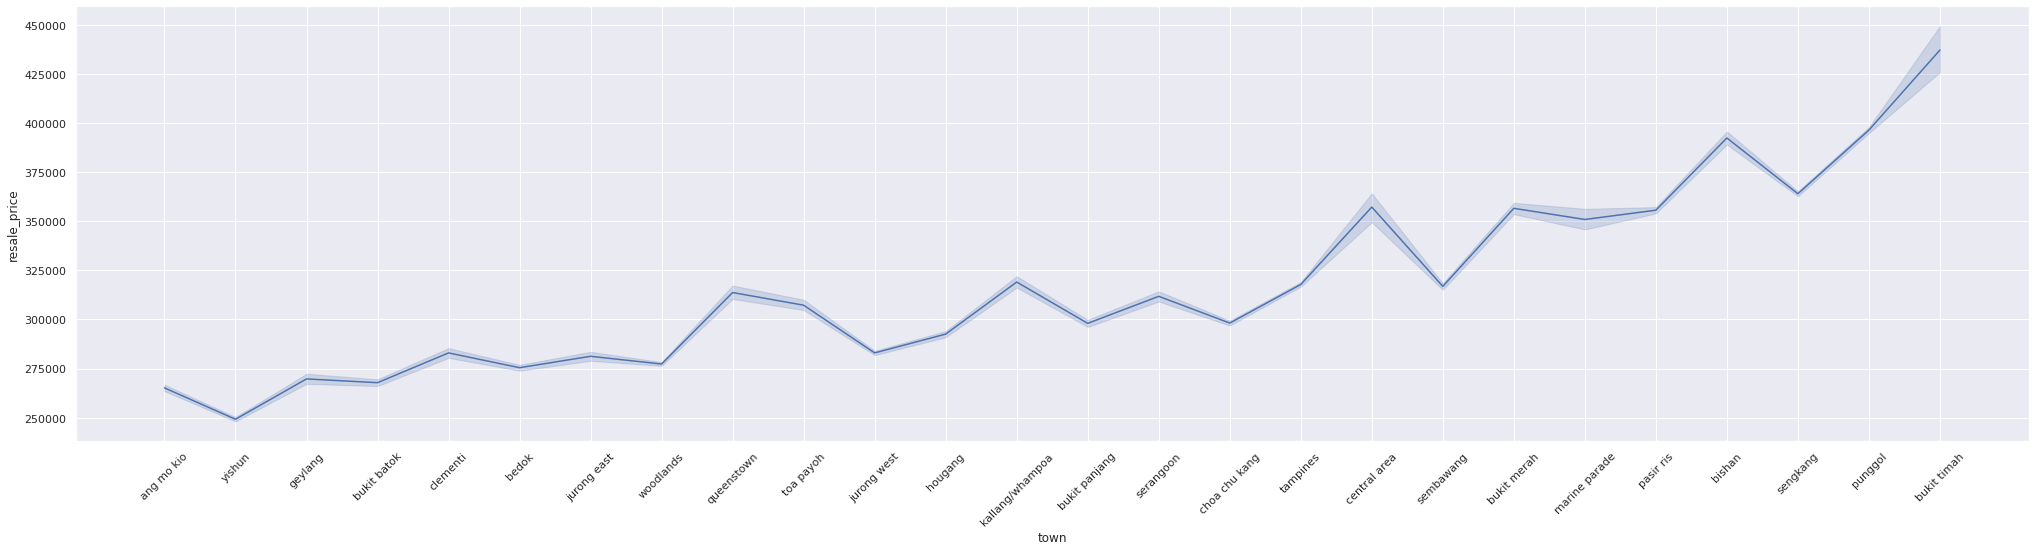

In [48]:
sns.set(rc={'figure.figsize':(35,8)})
sns.lineplot(x ='town', y ='resale_price', data = train_df.sort_values(by="upmarket_town", ascending=True))
plt.xticks(rotation=45);

# **Street**

In [49]:
dict_street_to_resale_price = dict(train_df.groupby(by='street_name')['resale_price'].median())
train_df['upmarket_street'] = train_df['street_name'].apply(lambda street: dict_street_to_resale_price[street] - overall_median_price)

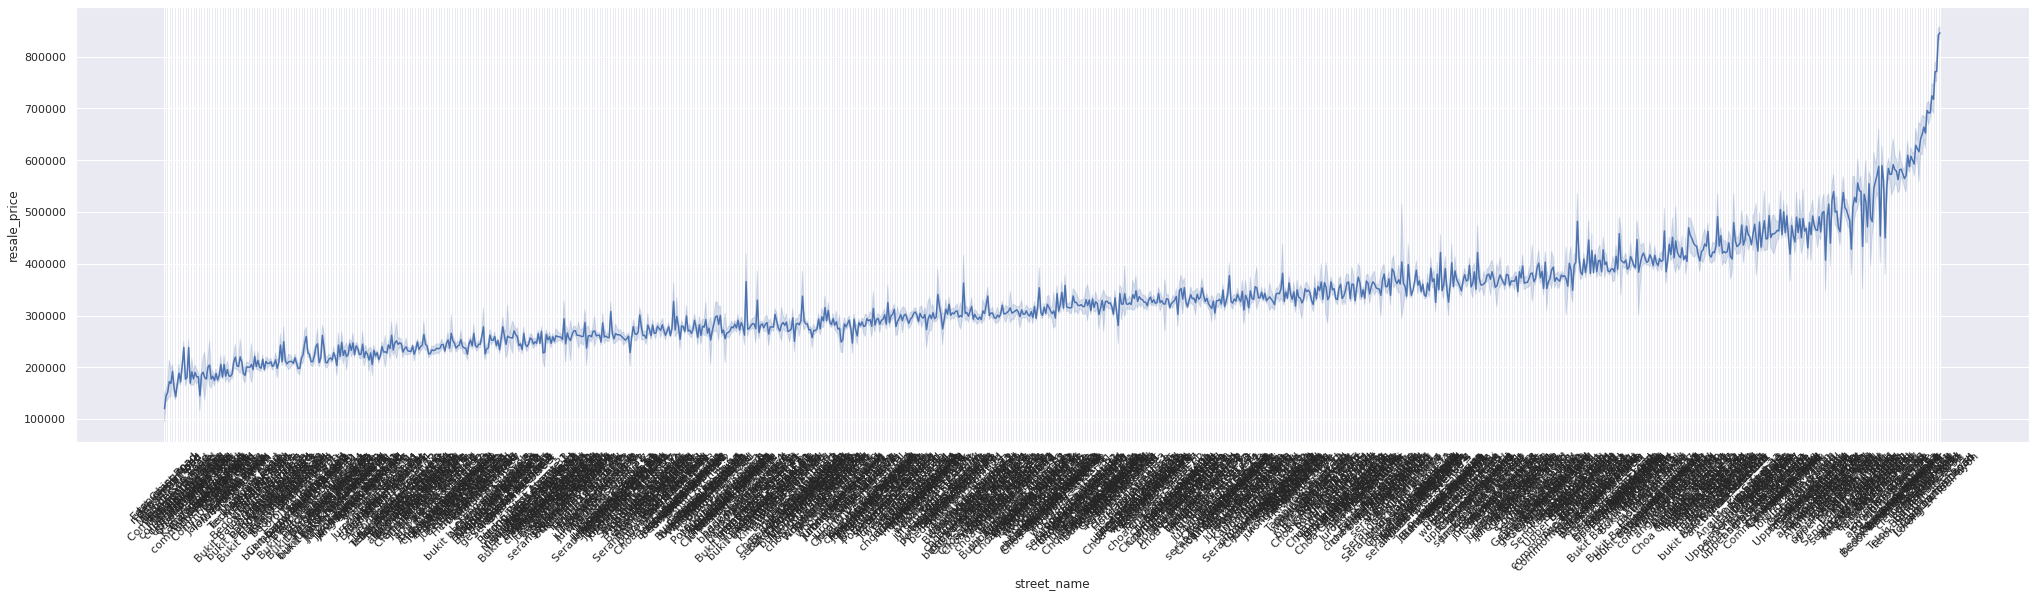

In [50]:
sns.set(rc={'figure.figsize':(35,8)})
sns.lineplot(x ='street_name', y ='resale_price', data = train_df.sort_values(by="upmarket_street", ascending=True))
plt.xticks(rotation=45);

# **Latitude and longitutudes**

Text(0.5, 1.0, 'HDB houses in Singapore')

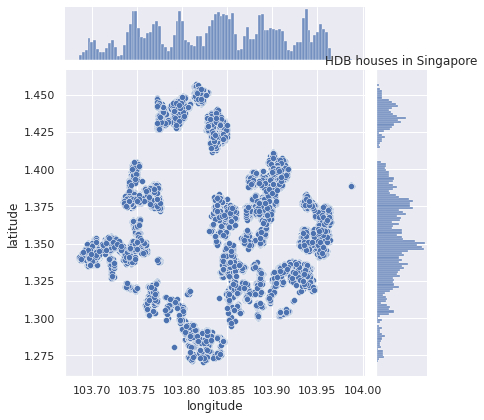

In [51]:
sns.jointplot(x ='longitude', y ='latitude', data = train_df)
plt.title('HDB houses in Singapore')

# **Region**

We notice that both mean and median resale price vary as we move from one region to another. Since there are only 5 regions, we can one hot encode this feature.

In [52]:
train_df.region.value_counts()

west region          109236
north-east region     85779
central region        82307
east region           77294
north region          76870
Name: region, dtype: int64

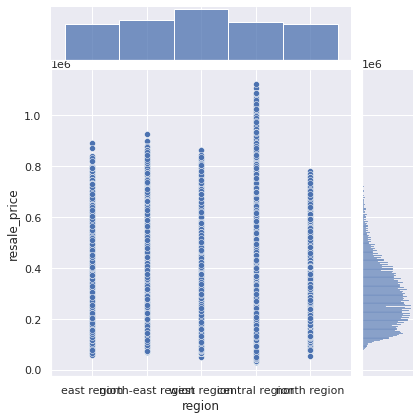

In [53]:
sns.set(rc={'figure.figsize':(20,8)})
sns.jointplot(x='region', y='resale_price', data=train_df)
# plt.xticks(rotation=45);

In [54]:
train_df.groupby(by='region')['resale_price'].median().sort_values(ascending=True)

region
north region         261000.0
west region          271800.0
central region       289800.0
east region          295200.0
north-east region    311110.2
Name: resale_price, dtype: float64

In [55]:
train_df.groupby(by='region')['resale_price'].mean().sort_values(ascending=True)

region
north region         271343.511185
west region          284974.596720
east region          310324.496234
north-east region    316188.695571
central region       328613.834593
Name: resale_price, dtype: float64

# **Auxiliary data**

Auxiliary data files such as sg-commerical-centres.csv, sg-gov-markets-hawker-centres.csv, sg-primary-schools.csv, sg-secondary-schools.csv, sg-secondary-schools.csv, sg-train-stations.csv contains latitude and longitudes of its respective place, we use this in combination with latitude and longtiudes given in our main dataset to compute distance between house and respective place, and find the distance of nearest mrt/hawker center..etc to each of the house

Note: since each of the operation takes approximately 1 hour to run, we have run that code separately and added auxliary data columns to our main dataset

we use custom written method (below) to compute distances, as it runs faster than other third party python packages. We utilize numpy as it is implemented in C++ language and leads to fast computation

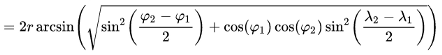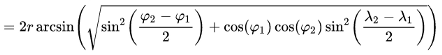


    def haversine_distance(lat1, lon1, lat2, lon2):
        r = 6371
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
        delta_phi = np.radians(lat2-lat1)
        delta_lambda = np.radians(lon2-lon1)
        a = np.sin(delta_phi / 2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda / 2)**2
        res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
        return np.round(res*1000, 2)

Let's analyze each of the auxilary data columns one by one.

population demographics auxiliary data has columns plannin_area and subzone which is also part of our main data. We utilize these columns to find average age of the poopulation, which is represnted by column pop_avg_age in our train_df

In [56]:
pop_demo = pd.read_csv('../input/cs5228-2020-semester-2-final-project/auxiliary-data/sg-population-demographics.csv')
pop_demo.head(1)

,plannin_area,subzone,age_group,sex,count
0,ang mo kio,ang mo kio town centre,0-4,m,130


In [57]:
train_df['pop_avg_age'].isnull().sum()

154

we see that pop_avg_age column has few missing values, that may be because that particular planning area and subzone pair wouldn't be there in auxilairy data.

In [58]:
train_df[train_df['pop_avg_age'].isnull()]['planning_area'].unique().item(), train_df[train_df['pop_avg_age'].isnull()]['subzone'].unique().item()

('downtown core', 'city hall')

All values corresponding to planning_area = downtown core, and subzone area = city hall are null. So we can fill missing values by average age value of downtown core planning area

In [59]:
demo = pd.read_csv('../input/cs5228-2020-semester-2-final-project/auxiliary-data/sg-population-demographics.csv')
downtown = demo[demo['plannin_area'] == 'downtown core']

def fn(x):
    s = x.split('-')
    if len(s)!= 1:
        l,h = s
        l = int(l)
        h = int(h)
        return 0.5*(l+h)
    else: #age category 85+
        return 88
    
downtown['avg_age'] = downtown['age_group'].apply(fn)
downtown_avg_age =  (downtown['count'] * downtown['avg_age']).sum() / downtown['avg_age'].sum()
downtown_avg_age

39.86561866125761

verifying there are no missing values

In [60]:
train_df['pop_avg_age'] = train_df['pop_avg_age'].fillna(downtown_avg_age)
train_df['pop_avg_age'].isnull().sum() 

0

# MRT

While calculating nearest distance to MRT, we also took into consideration, that mrt house resale year is after mrt opening year. This is imporatant because house which was sold in 1990 will no impact of nearby MRT station which opened in year 2010

In [61]:
mrtt = pd.read_csv('../input/cs5228-2020-semester-2-final-project/auxiliary-data/sg-train-stations.csv')
mrtt.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


Cleaning MRT data

In [62]:
mrtt.name.value_counts()

Sengkang         2
Choa Chu Kang    2
Punggol          2
Bukit Panjang    2
Nibong           1
                ..
Bras Basah       1
Pasir Panjang    1
Downtown         1
Tan Kah Kee      1
Pending          1
Name: name, Length: 162, dtype: int64

4 MRT stations - Sengkang ,Choa Chu Kang, Punggol ,Bukit Panjang are repeated twice and have latitudes and longitudes, we remove one of the repeated entries

In [63]:
mrtt[mrtt['name'] == 'Bukit Panjang']

,name,codes,lat,lng,opening_year,type
45,Bukit Panjang,BP6,1.377909,103.763013,2015.0,mrt
148,Bukit Panjang,DT1,1.379001,103.761535,2015.0,mrt


In [64]:
mrtt.drop([47, 18, 45, 82], inplace=True)

Few of the stations doesn't have type 'mrt' assigned to them and also opening year is missing for them. Thus we use it with our main data. So we remove them

In [65]:
mrtt[mrtt['type'] == 'other'].head()

,name,codes,lat,lng,opening_year,type
40,Oasis,PE6,1.402286,103.912727,NaN,other
41,Sam Kee,PW1,1.409612,103.904831,NaN,other
42,Farmway,SW2,1.397170,103.889304,NaN,other
43,Kupang,SW3,1.398212,103.881256,NaN,other
44,Renjong,SW8,1.386723,103.890539,NaN,other


In [66]:
other_idx = mrtt[mrtt['type'] == 'other'].index
mrtt.drop(other_idx, inplace=True)
mrtt.reset_index(drop=True,inplace=True)

from the cleaned mrt data above we calculated nearby mrt distance (in meters) for each house, represented by column 'mrt' in our main dataset i.e. train_df.

In [67]:
train_df['mrt'].head()

0    1137.16
1     824.05
2    2230.48
3     423.66
4     774.56
Name: mrt, dtype: float64

Text(0.5, 1.0, 'Spread of MRT in Singapore')

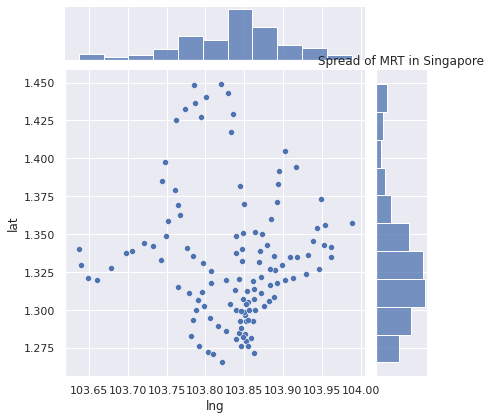

In [68]:
sns.jointplot(x ='lng', y ='lat', data = mrtt)
plt.title('Spread of MRT in Singapore')

As we go closer and closer to MRT, resale price increases

In [69]:
d = [1000,700,500,300,200]
col = 'mrt'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

Mean price:  308424.5525710404     Median price:  288000.0
Mean price:  319260.4254427752     Median price:  297000.0
Mean price:  331302.8933197736     Median price:  308700.0
Mean price:  348569.01245414343     Median price:  325800.0
Mean price:  371116.7147563273     Median price:  346500.0


# Hawker market and centers

As we go very close to hawker centers and markets price actually decreases, this could be because people want to avoid to the noise, smell

In [70]:
d = [1000,700,500,300]
col = 'hawker'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

Mean price:  292120.0620798878     Median price:  268200.0
Mean price:  287977.9283393161     Median price:  261000.0
Mean price:  285366.8219666559     Median price:  256500.0
Mean price:  281822.2396410156     Median price:  250200.0


# Primary school and Secondary schools

In [71]:
primary_school = pd.read_csv('../input/cs5228-2020-semester-2-final-project/auxiliary-data/sg-primary-schools.csv')
secondary_school = pd.read_csv('../input/cs5228-2020-semester-2-final-project/auxiliary-data/sg-secondary-schools.csv')

In [72]:
d = [1000,700,500,300]
col = 'ps'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

print('\n')
col = 'ss'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

Mean price:  301926.2432630717     Median price:  284400.0
Mean price:  302392.9225613898     Median price:  286200.0
Mean price:  303934.3976268173     Median price:  288000.0
Mean price:  307331.0002772299     Median price:  292500.0


Mean price:  299518.48851968866     Median price:  283500.0
Mean price:  299068.4409996922     Median price:  283500.0
Mean price:  298409.47448263055     Median price:  283500.0
Mean price:  295433.13224246114     Median price:  281700.0


In [73]:
len(train_df[train_df['ps'] <= 500])

320896

In [74]:
len(train_df[train_df['ss'] <= 500])

253793

There are 320896 (~ 75%) houses which have primary schools within 500m, and 253793 (~ 60%) houses which have secondary schools within 500m which shows schools are spread out throughout singapore. Same spread as well as denseness is shown using plot below. We choose axes such that the plot shape resembles Singapore Map, which makes easier for us to analyze. Since schools are fairly common and have extremely low co relation to resale price, we can drop these auxlary data feature columns

Text(0.5, 1.0, 'Spread of Primary Schools in Singapore')

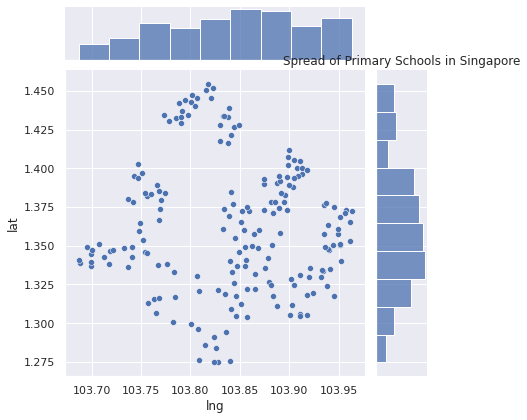

In [75]:
sns.jointplot(x ='lng', y ='lat', data = primary_school)
plt.title('Spread of Primary Schools in Singapore')

Text(0.5, 1.0, 'Spread of Secondary Schools in Singapore')

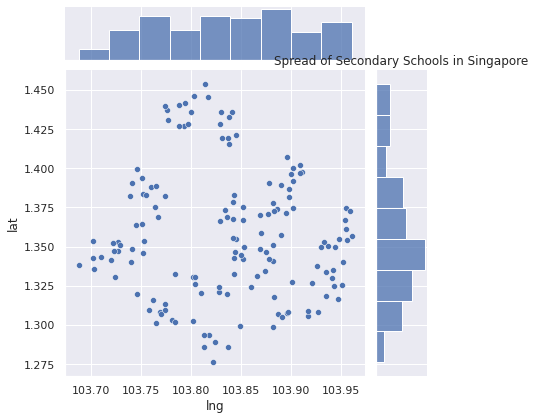

In [76]:
sns.jointplot(x ='lng', y ='lat', data = secondary_school)
plt.title('Spread of Secondary Schools in Singapore')

# Shopping Mall

We can notice that as we go closer to shopping malls, prices increases or remains almost the same. Its coorelation factor (- 0.07) to resale_price is weak. So we keep the column for now and decide its relevance in prediction later

In [77]:
d = [1000,700,500,300]
col = 'sm'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

Mean price:  306012.42213214986     Median price:  288000.0
Mean price:  311262.32985064096     Median price:  295200.0
Mean price:  311991.01807829854     Median price:  295200.0
Mean price:  310959.157528403     Median price:  295200.0


# Commercial centers

As we move close to commercial centers, prices tends to increase

In [78]:
d = [1000,700,500,300]
col = 'cc'
for dt in d:
    print('Mean price: ', train_df[train_df[col] <= dt]['resale_price'].mean(), '    Median price: ', train_df[train_df[col] <= dt]['resale_price'].median())

Mean price:  321125.4367412619     Median price:  297000.0
Mean price:  325286.6847143964     Median price:  299700.0
Mean price:  334019.4711608226     Median price:  307800.0
Mean price:  357824.8194312799     Median price:  328500.0


**Checking for any duplicate rows**

In [79]:
train_df_dup_rows = train_df[train_df.duplicated()] #315 duplicate rows
len(train_df_dup_rows)

1987

there are 315 duplicate rows, one of the example is as shown:-

In [80]:
#checking duplicate rows- filter by features for verification
train_df[(train_df['block'] == '297A') & (train_df['flat_model'] == 'premium apartment') & (train_df['town'] == 'sengkang') & (train_df['storey_range'] == '07 to 09') & (train_df['resale_price'] == 315000.0)]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,...,hawker,ps,ss,sm,cc,pop_avg_age,resale_year,upmarket_model,upmarket_town,upmarket_street


In [81]:
train_df = train_df.drop_duplicates()

In [82]:
df_copy = train_df.copy()

In [83]:
train_df = df_copy

Final dataframe

In [84]:
df_copy.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,...,hawker,ps,ss,sm,cc,pop_avg_age,resale_year,upmarket_model,upmarket_town,upmarket_street
0,pasir ris,4 room,440,pasir ris drive 4,2,118.0,model a,1989,1.369008,103.958697,...,945.56,344.09,428.30,1033.22,2313.57,37.171904,2001,-5400.0,63450.0,48150.0
1,punggol,5 room,196B,punggol field,11,110.0,improved,2003,1.399007,103.906991,...,3782.39,160.85,312.38,806.04,1462.43,34.546316,2014,18900.0,110700.0,103500.0
2,sengkang,5 room,404A,fernvale lane,2,112.0,premium apartment,2004,1.388348,103.873815,...,1803.94,184.91,558.38,452.56,1444.92,32.509407,2020,85500.0,82800.0,94500.0
3,clementi,3 room,375,clementi avenue 4,8,67.0,new generation,1980,1.318493,103.766702,...,618.29,304.56,619.13,456.50,2387.09,43.511127,2000,-69300.0,-31500.0,-53100.0
4,bukit batok,3 room,163,bukit batok street 11,8,73.0,model a,1985,1.348149,103.742658,...,761.92,233.81,217.91,764.17,1807.09,39.087869,2013,-5400.0,-36000.0,-27000.0


# Feature transformation

**converting flat_type to one hot encoded**

In [85]:
train_df_ft = pd.get_dummies(train_df["flat_type"],prefix='ft',drop_first=True)
train_df = train_df.join(train_df_ft)
train_df.drop(['flat_type'], axis=1, inplace=True)

**converting region to one hot encoded**

In [86]:
train_df_reg = pd.get_dummies(train_df["region"],prefix='reg',drop_first=True)
train_df = train_df.join(train_df_reg)
train_df.drop(['region'], axis=1, inplace=True)

dropping columns selectively and alternatively in order to try out different columns, not all features will important say in final prediction

In [87]:
train_df.drop(['town','flat_model','block', 'street_name', 'subzone', 'planning_area','hawker','latitude','longitude'], inplace=True, axis=1)#'latitude','longitude'
train_df.drop(['ps','ss','sm', 'cc'], inplace=True, axis=1) #aux data

# train_df.drop(['upmarket_town'], inplace=True, axis=1)

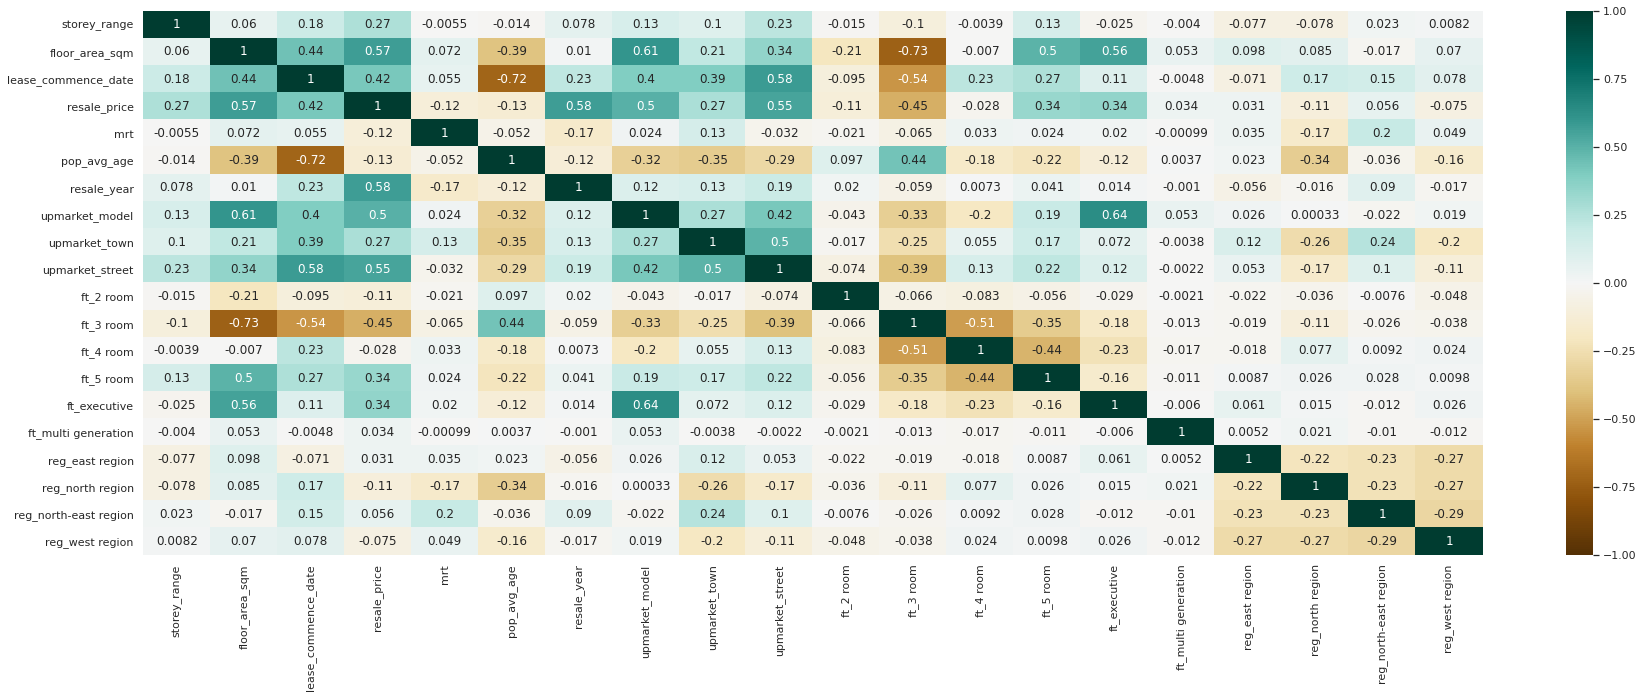

In [88]:
sns.set(rc={'figure.figsize':(30,10)})
heatmap = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

**Feature Normalization**

In [89]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

Split into train and valid data

In [90]:
df_X =  train_df.drop(['resale_price'] ,axis=1)
df_y = train_df['resale_price']

cols = df_X.columns
arr = scaler.fit_transform(df_X)
df_X = pd.DataFrame(data=arr, columns= cols)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.05)

**Trying out different regression models**

In [91]:
%%time

# model = linear_model.LinearRegression()
# model = linear_model.Lasso(alpha=0.1)
# model = linear_model.Ridge(alpha=0.1)
# model= linear_model.ElasticNet(alpha=0.1) 
# model = DecisionTreeRegressor()
model = RandomForestRegressor()
# model = GradientBoostingRegressor(max_depth = 200, min_samples_split = 6, n_estimators = 300)
# model = LGBMRegressor()
# model = XGBRegressor(max_depth = 50,n_estimators = 300)
# model = AdaBoostRegressor()
# model = MLPRegressor()



model.fit(X_train, y_train)
preds = model.predict(X_test)
mean_squared_error(y_test, preds, squared=False)

CPU times: user 4min 24s, sys: 2.34 s, total: 4min 26s
Wall time: 4min 26s


19678.05714712973

Best model is obtained as GradientBoostingRegressor(max_depth = 10, min_samples_split = 5, n_estimators = 200) which achieved rmse on 16558 on kaggle leaderboard.

Generate submission csv

In [92]:
# test_train_df = pd.read_csv('../input/cs5228-2020-semester-2-final-project/test.csv')

# arr = scaler.fit_transform(test_df)
# cols = test_df.columns
# test_df = pd.DataFrame(data=arr, columns= cols)
# test_pred = model.predict(test_df)
# output = pd.DataFrame({'Id': test_df.index,'Predicted': test_pred})
# output.to_csv('submission.csv', index=False)